## Timings

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings
import random


if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import data_conv
import libra_py.data_outs as data_outs
import libra_py.data_savers as data_savers
import libra_py.tsh as tsh
import libra_py.tsh_stat as tsh_stat

import libra_py.dynamics.tsh.compute as tsh_dynamics
#import libra_py.dynamics.tsh.save as save
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot


import libra_py.dynamics.exact.compute as exact_dynamics
#import libra_py.dynamics.exact.save as save
import libra_py.dynamics.exact.plot as exact_dynamics_plot

from libra_py import dynamics_plotting

#from matplotlib.mlab import griddata
%matplotlib inline 

warnings.filterwarnings('ignore')

/home/story/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/story/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/story/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::alloca

In [2]:
colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray
colors.update({"42": "#000080"})  # navy blue

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24", "42"]

The calculations were run externally and the data imported for plotting. The script for testing the runtimes is shown below but the execution of the tests are commented out. The CPU used is Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz.

First, we define a function to construct time-overlap matrices of different types and sizes. Trivial crossings are simluated by column permutations, which are controlled by the `frac_triv` argument. The number of state degeneracies are controlled by the `num_degen` argument. The maximum number of degenerate states is the number of states minus number of trivial crossings all divided by 3. 

In [3]:
def make_time_overlap_matrix(nstates, frac_triv, num_degen ,rnd, printout = 0):

    # Initial, well-behaved matrix
    st = CMATRIX(nstates,nstates)
    for i in range(nstates):
        st.set(i, i,  (0.9 + 0.1* rnd.uniform(-1.0, 1.0)) * (1.0+0.0j) )

        for j in range(nstates):
            if i < j:
                s_ij = ( (0.1 + 0.02*rnd.uniform(-1.0, 1.0)) / (abs(i-j)*nstates) ) * (1.0+0.0j)
                st.set(i, j, s_ij )
                st.set(j, i, s_ij )


    # "Deform" the well-behaved matrix: trivial crossings
    #============== Trivial crossings ================
    aux_perm = random.sample( range(nstates), int(nstates * 0.5*frac_triv) )  # select to permute
    nperm = len(aux_perm)

    trivial_permutations = list(range(nstates))

    for i in range(nperm):
        j = aux_perm[i]
        x = trivial_permutations[i]
        trivial_permutations[i] = trivial_permutations[j]
        trivial_permutations[j] = x

    st.permute_cols(Py2Cpp_int(trivial_permutations))


    #============== Degeneracy splits ================
    unchanged = []
    for i in range(nstates):
        if trivial_permutations[i] == i:
            unchanged.append(i)

    n_unchanged = len(unchanged)

    degen = []
    for i in range(num_degen):
        i1 = unchanged[3*i]
        i2 = unchanged[3*i+1]
        i3 = unchanged[3*i+2]
        degen.append(i1)
        degen.append(i2)
        degen.append(i3)
        
        if printout:
            print(F"{i1} -> {i2}, {i3}")

        half1 = 0.5*st.get(i1, i1)
        half2 = 0.5*st.get(i1, i1)+ 0.2
        sum_ = st.get(i1, i2) + st.get(i1, i3)

        st.set(i1, i1, sum_)
        st.set(i1, i2, half1)
        st.set(i1, i3, half2)


        if printout:
            print(F"{i2} -> {i1}, {i3}")

        half1 = 0.5*st.get(i2, i2)
        half2 = 0.5*st.get(i2, i2) + 0.2
        sum_ = st.get(i2, i1) + st.get(i2, i3)

        st.set(i2, i2, sum_)
        st.set(i2, i1, half2)
        st.set(i2, i3, half1)


        if printout:
            print(F"{i3} -> {i1}, {i2}")

        half1 = 0.5*st.get(i3, i3)
        half2 = 0.5*st.get(i3, i3) + 0.2
        sum_ = st.get(i3, i1) + st.get(i3, i2)

        st.set(i3, i3, sum_)
        st.set(i3, i1, half1)
        st.set(i3, i2, half2)

    if printout:
        print('aux_perm, trivial_permutations, unchanged, degen')
        print(aux_perm, trivial_permutations, unchanged, degen)


    return st

The matrix must also be normalized, which is done by the function defined below.

In [4]:
def renormalize(st):
    res = CMATRIX(st)
    nstates = st.num_of_cols
    for i in range(nstates):
        row_sum = 0
        for j in range(nstates):
            row_sum += res.get(i,j)
        res.scale(i, -1, (1 / row_sum))
    return res

Finally, we can combine these functions to measure the timings of the state tracking algorithms. The timings are done by repeatly calling the algorithm until the total runtime is at least 30 seconds. This is done 10 times for each algorithm. There are then a total of 20 data points for each system size, which are stored in an hdf file. The number of states and repititions are also stored in the hdf file to be used for analysis/plotting.

In [5]:
def test_timings(filename, frac_triv, num_degen):
    nruns = 10
    states = [12, 25, 50, 100, 200, 400, 600, 800, 1000]
    repetitions_mincost = [2853268, 1459734, 442592, 133025, 35701, 8838, 4092, 2273, 1455]
    repetitions_stoch = [1402777, 454092, 139716, 32740, 7499, 2911, 603, 351, 205]

    if os.path.isfile(f'timings_{filename}.hdf5'):
        os.system(f'rm timings_{filename}.hdf5')

    with h5py.File(f'timings_{filename}.hdf5', 'w') as f:

        for i in range(len(states)):
            n = states[i]
            reps_min = repetitions_mincost[i]
            reps_sto = repetitions_stoch[i]

            rnd = Random()      
            st = make_time_overlap_matrix(states[i], frac_triv, num_degen ,rnd)
            st = renormalize(st)

            # empty array to store data in
            data_array = np.empty((nruns, 2)) # run, algorithm

            MK_alpha = 0
            MK_verbosity = 0
            convergence = 1
            max_number_attemps = 1000
            Eadi_traj = CMATRIX(n,n)
            for i in range(n):
                Eadi_traj.set(i, i, 10)

            rnd = Random()
            for run in range(nruns):
                start = time.time()
                for rep in range(reps_min):
                    Munkres_Kuhn(st, Eadi_traj, MK_alpha, MK_verbosity)
                end = time.time()
                data_array[run, 0] = end-start

                start = time.time()
                for rep in range(reps_sto):
                    get_stochastic_reordering3(st, rnd, convergence, max_number_attemps)
                end = time.time()
                data_array[run, 1] = end-start

            # add data to hdf
            f.create_dataset(f'{n}', data = data_array)
        # add input data to hdf
        input_array = np.array((states,repetitions_mincost, repetitions_stoch))
        f.create_dataset('input', data = input_array)

The following cell shows the parameters used, but is commented out because it takes a long time to run and the output files are already provided.

In [6]:
#test_timings('non_deformed', 0, 0)
#test_timings('crossings', 0.5, 0)
#test_timings('degen', 0, 2)
#test_timings('both', 0.2, 2)

Once the timings calulcations are run and stored in hdf files, we need to unpack, manipulate, and plot the data.

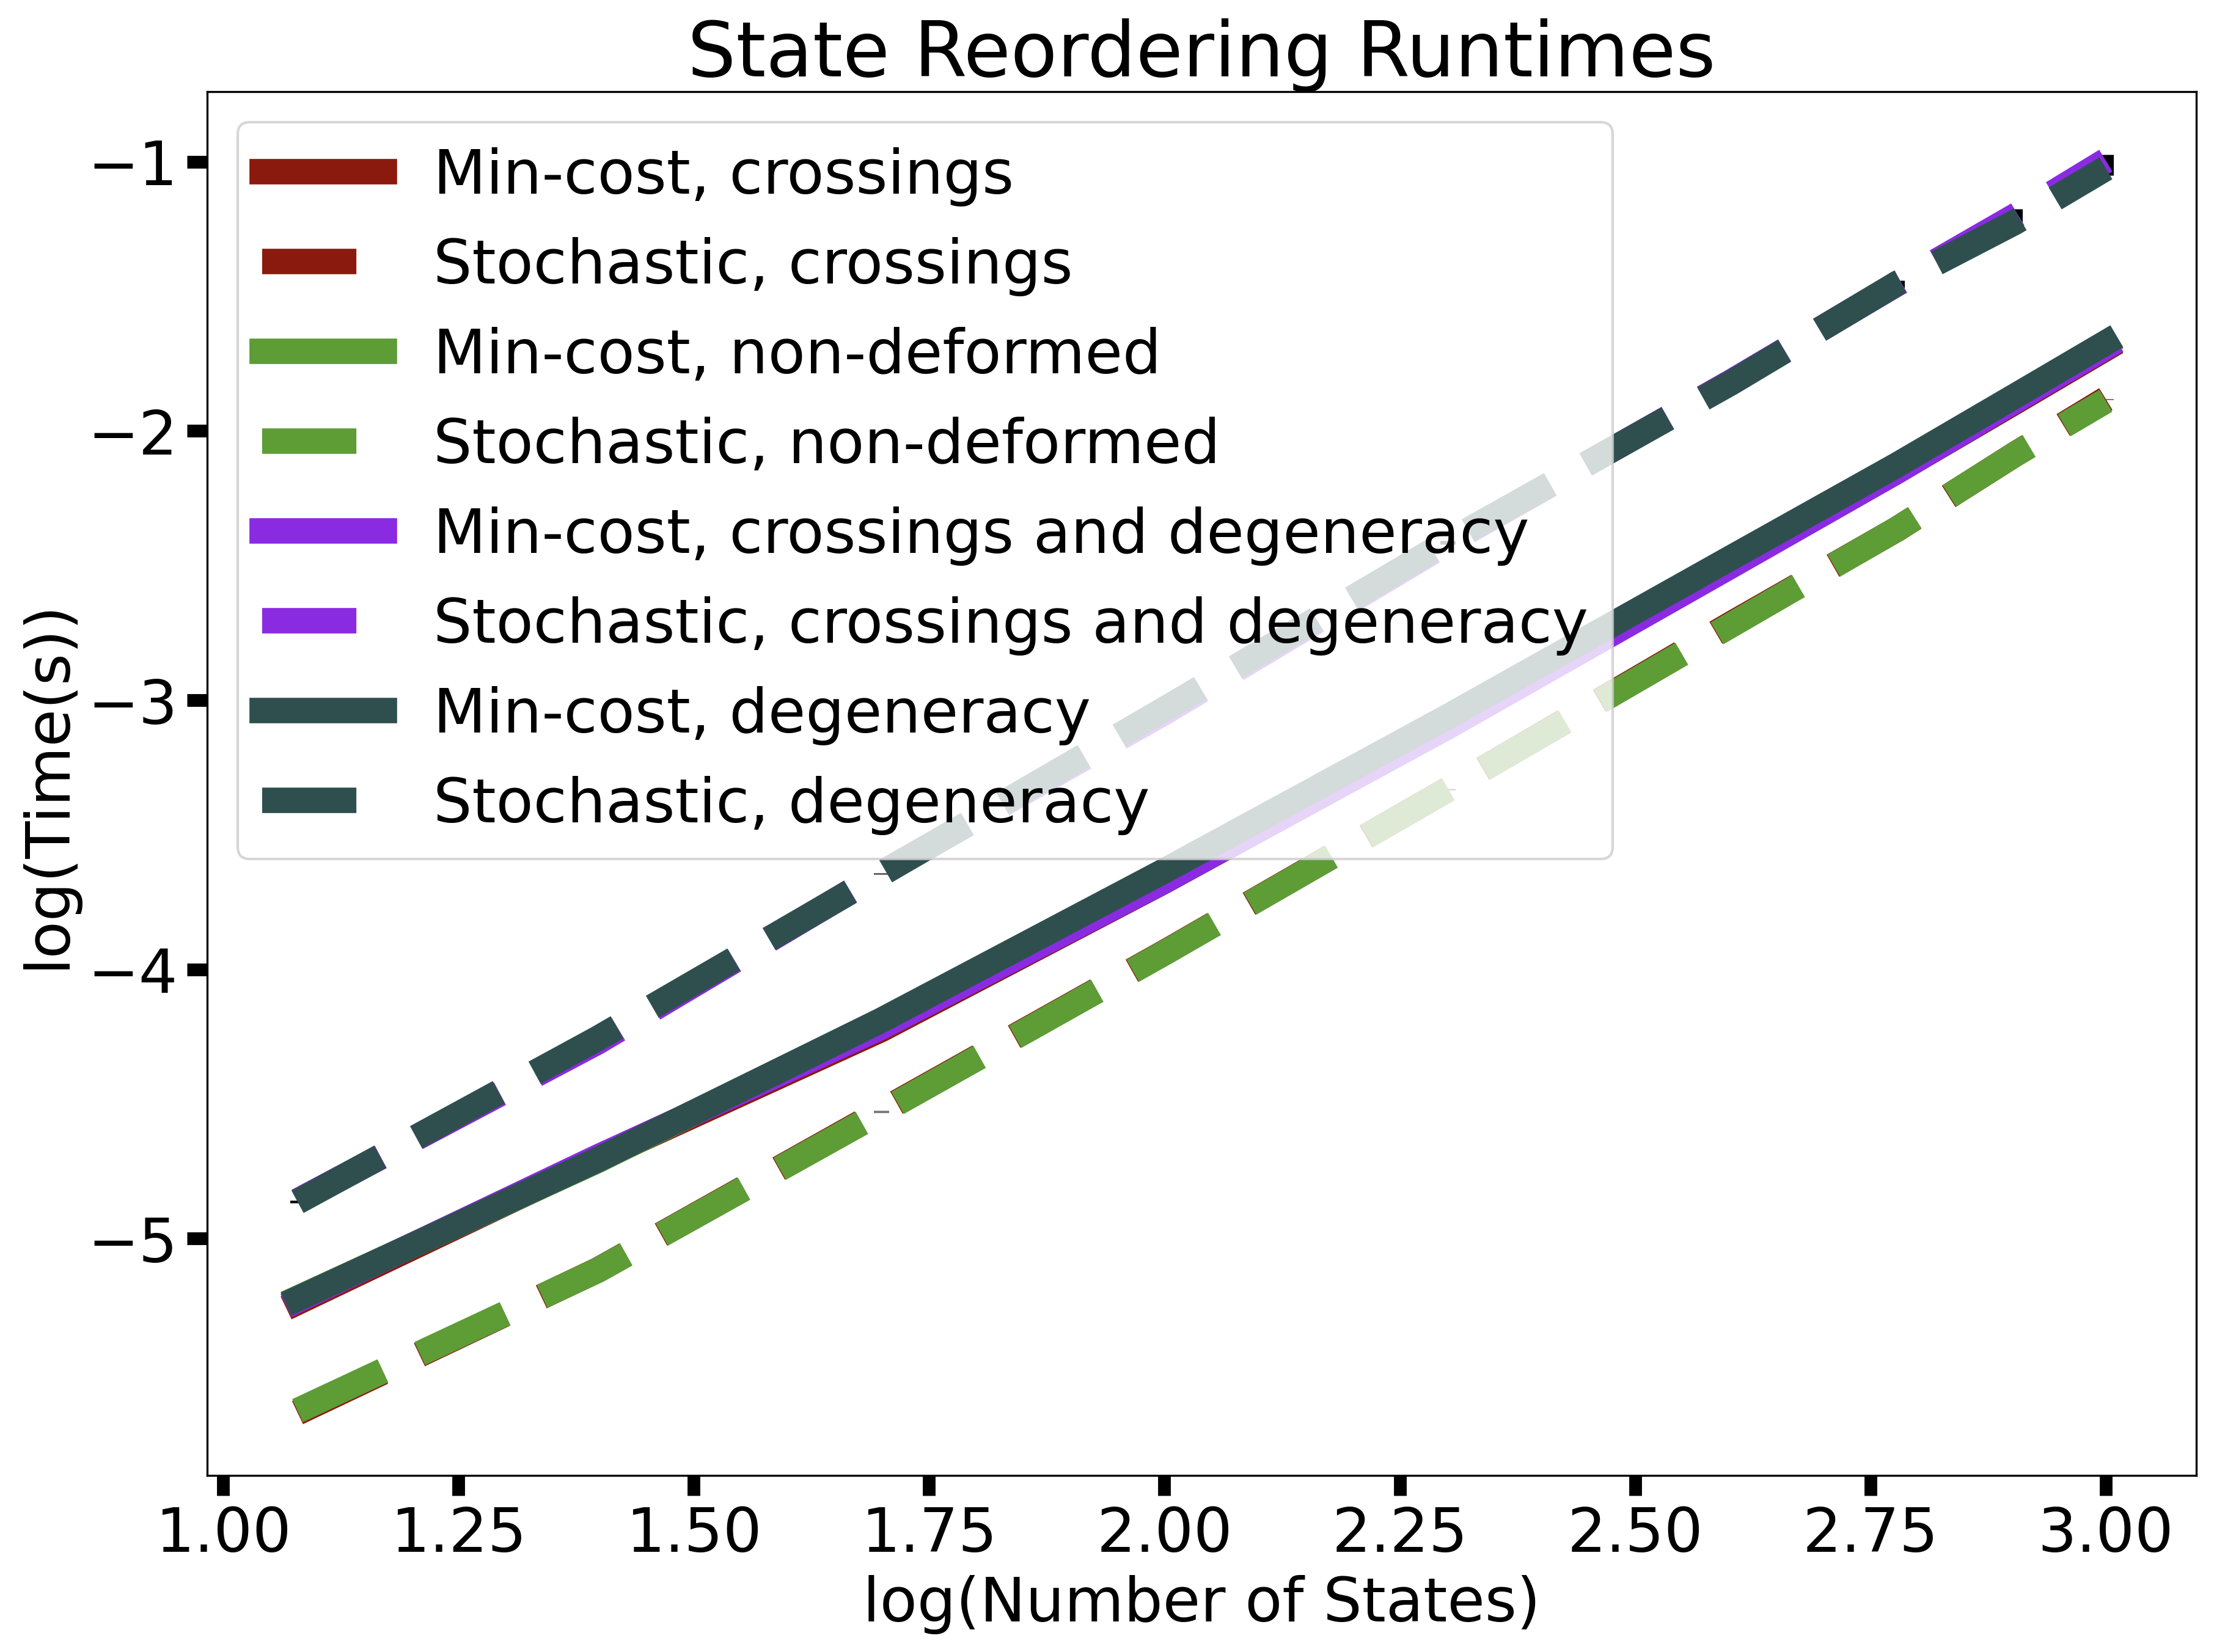

In [7]:
plt.figure(figsize=(14,10), dpi=300, frameon=False)
plt.title('State Reordering Runtimes', fontsize = 30)
plt.xlabel('log(Number of States)', fontsize = 24)
plt.ylabel('log(Time(s))', fontsize = 24)
ax = plt.gca()
ax.tick_params(labelsize=24, width=5, length=8) 

# list of hdf file names to plot
filenames = ['crossings', 'non_deformed', 'both', 'degen']
# how the datasets will be labeled in the legend
titles = ['crossings', 'non-deformed', 'crossings and degeneracy', 'degeneracy']
log_states = 0
cnt = 0
for i in range(len(filenames)):
    filename = filenames[i]
    title = titles[i]
    with h5py.File(f'timing_data/timings_{filename}.hdf5', 'r') as f:
        mincost = []
        stoch = []
        mincost_error = []
        stoch_error = []

        states = f['input'][0, :]
        repetitions_mincost = f['input'][1, :] 
        repetitions_stoch = f['input'][2, :]

        nstates = len(states)
        for dataset in range(nstates):
            n = states[dataset]
            data = np.array(f[f'{n}'])
            mtemp = []
            stemp = []
            # for each data point
            for point in range(10):
                # divide total run time by number of repetitions to obtain runtime of single call
                m = data[point, 0]/repetitions_mincost[dataset]
                s = data[point, 1]/repetitions_stoch[dataset]
                # find the logarithm 
                m = math.log(m, 10)
                s = math.log(s, 10)
                # append to temporary list
                mtemp.append(m)
                stemp.append(s)
            # append average and standard deviation to list that will be plotted
            mincost.append(np.average(mtemp))
            stoch.append(np.average(stemp))
            mincost_error.append(np.std(mtemp))
            stoch_error.append(np.std(stemp))

            
            if not log_states:
                log_states = []
                for state in range(len(states)):
                    log_states.append(math.log(states[state], 10))
                
        plt.errorbar(log_states, mincost, yerr = mincost_error, label=f'Min-cost, {title}', ls = '-',
                         color = colors[clrs_index[cnt]], ecolor = 'black', elinewidth = 6, linewidth = 10)     
        plt.errorbar(log_states, stoch, yerr = stoch_error, label=f'Stochastic, {title}', ls = '--',
                         color = colors[clrs_index[cnt]], ecolor = 'black', elinewidth = 6 , linewidth = 10)  
        cnt += 1
# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax.legend(handles, labels, loc='upper left',numpoints=1, fontsize = 24)